In [1]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
from suite3d import nbtools as nbui

In [4]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-06',
    'expnum' :         [1,2,3,4]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21])[n.array([6,7,8,9,10,11,12])],
    # number of files to use for the initial pass
    'n_init_files' :   3,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 7,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : False,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str + 'subset', tifs = tifs[:20],
          params=job_params, create=True, overwrite=True, verbosity = 3)

Loading job directory for SS003_2024-08-06_1-2-3-4subset in /mnt/md0/runs
      Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/registered_fused_data
      Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/summary
      Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [5]:
job.params['voxel_size_um'] = (20, 2.5, 2.5)

   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00006.tif
    Loaded file into shared memory in 18.48 sec
    Workers completed in 0.99 sec
    Total time: 19.47 sec
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00011.tif
    Loaded file into shared memory in 17.00 sec
    Workers completed in 0.96 sec
    Total time: 17.96 sec
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00016.tif
    Loaded file into shared memory in 16.56 sec
    Workers completed in 1.11 sec
    Total time: 17.67 sec
   Loaded 3 files, total 2.53 GB
   int16
   Loaded movie with 300 frames and shape 7, 900, 720
   int16
      Enforcing positivity in mea

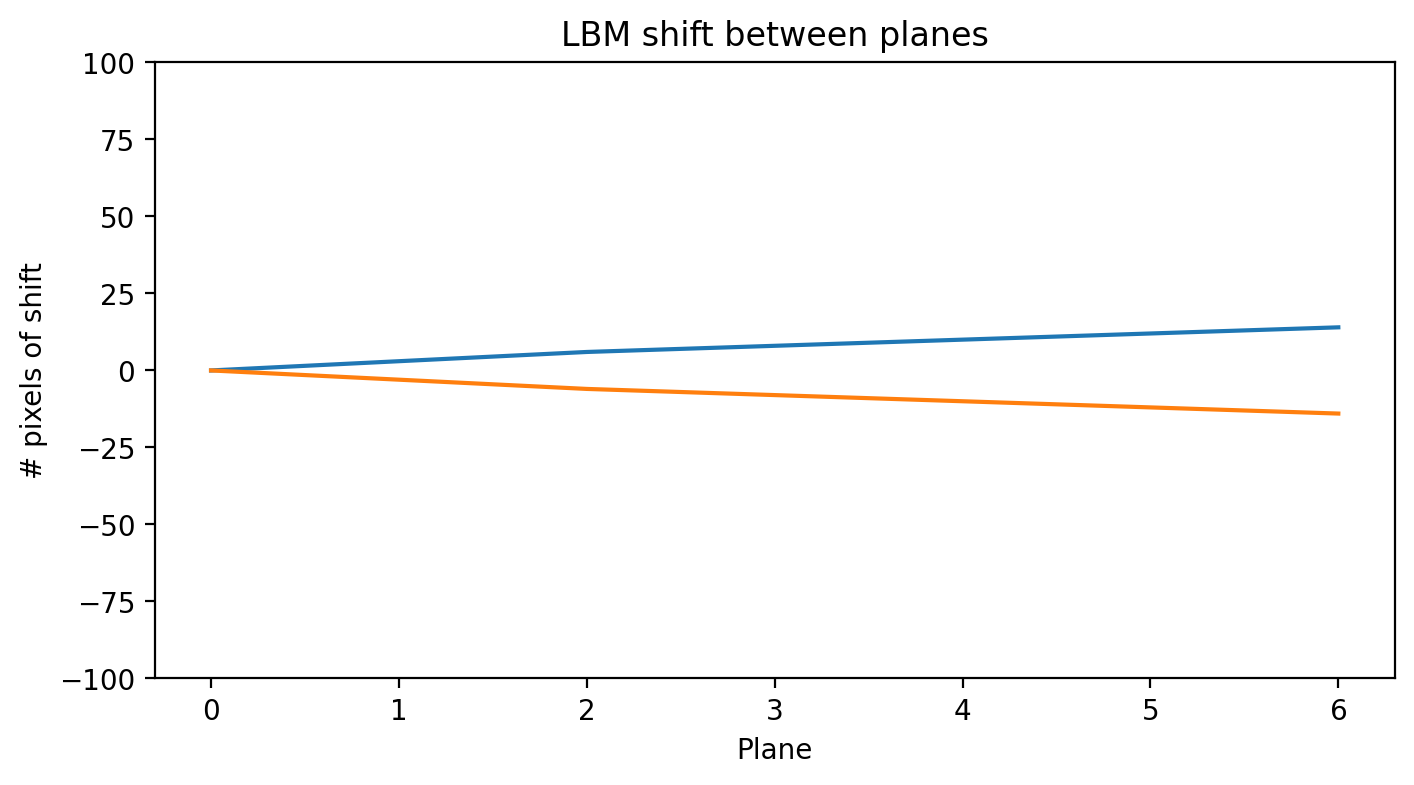

In [6]:
%%time
job.run_init_pass()

In [7]:
img3d = job.load_summary()['ref_img_3d']

In [8]:
img3d = img3dJ

(<Figure size 1050x750 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f193ad690a0>)

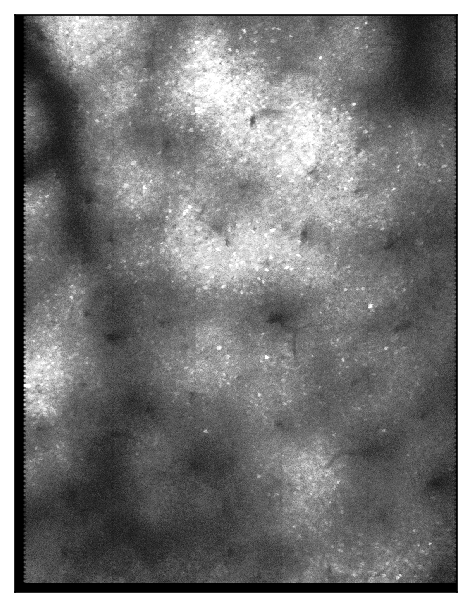

In [84]:
tfu.show_tif(img3d[0], figsize=(7,5))

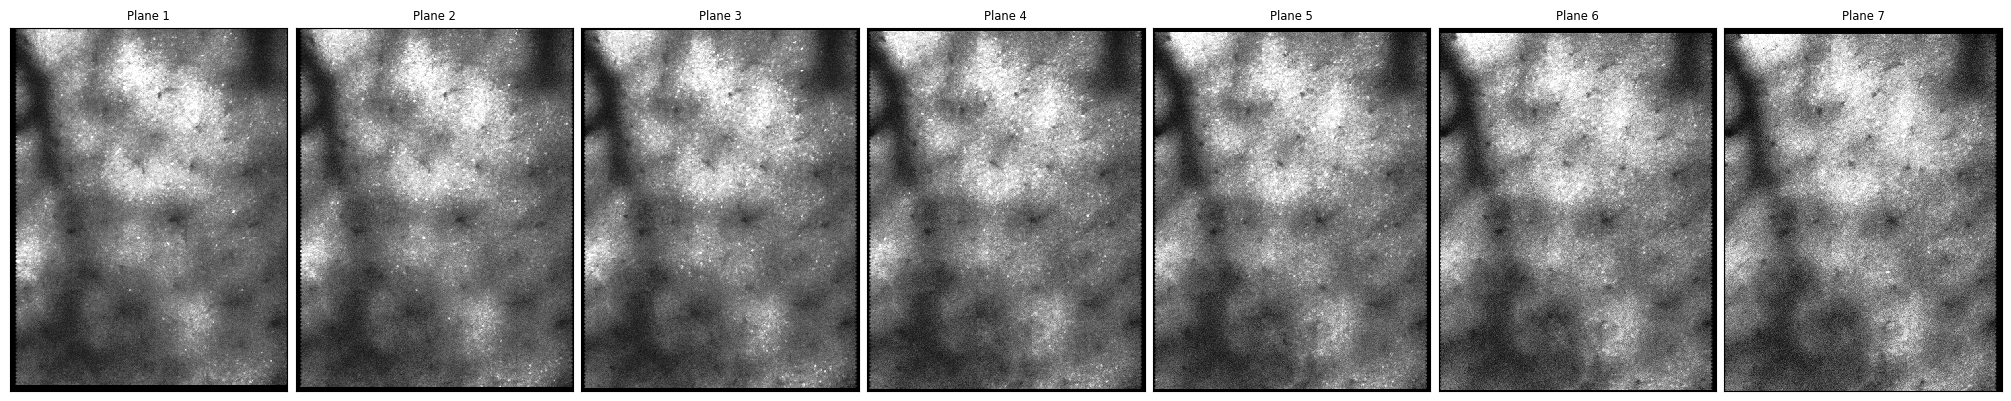

In [10]:
tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,5))

In [16]:
n.sort(xs)

array([  0, 144, 288, 288, 432, 576])

In [ ]:
# # SAVE DATA FOR s2p Run
# from suite3d.io.s3dio import s3dio
# from suite3d import reference_image as ref
# import tifffile

# jobio = s3dio(job)

# raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/raw'

# os.makedirs(raw_data_path,exist_ok=True)

# planes = n.array([6,7,8,9,10,11,12])
# fuse_shift = 7
# ys, xs = jobio._load_roi_start_pix_lbm(job.params)
# for tif in job.tifs[:20]:
#     print(tif)
#     data = jobio.load_data([tif], planes = job.params['planes'])
#     out_fname = tif.split('/')[-1].split('.')[0] + f'_{len(planes)}planes.tif'
#     out_path = os.path.join(raw_data_path, out_fname)
#     data = ref.fuse_mov(data, fuse_shift, n.sort(xs))[0]
#     data = n.swapaxes(data,0,1)        
#     tifffile.imsave(out_path, data)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

In [139]:
# tfu.show_tif_all_planes(data.mean(axis=1), ncols=7, figsize=(20,5),vminmax=(100,5000))

In [140]:
# tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,5),vminmax=(100,5000))

In [20]:
%%time
job.register(tifs=job.tifs)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Overriding fuse shift value to 7
   Not clipping frames for registration
Will analyze 20 tifs in 20 batches
   Enforcing positivity
   Launching IO thread
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00001.tif
         Memory at batch 0.  Total Used: 081.213 GB, Virtual Available: 437.668 GB, Virtual Used: 065.528 GB, Swap Used: 015.686 GB
Loading Batch 0 of 19
    Loaded file into shared memory in 13.09 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.74 sec
    Total time: 14.83 sec
   Loaded 1 files, total 0.84 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 082.023 GB, Virtual Available: 436.858 GB, Virtual Used: 066.338 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.868 GB, Virtual Available: 436.013 GB, Virtual Used: 067.183 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 079.564 GB, Virtual Available: 439.317 GB, Virtual Used: 063.879 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 079.564 GB, Virtual Available: 439.317 GB, Virtual Used: 063.879 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00002.tif
      Loaded batch of size (7, 100, 900, 720)
   Completed rigid reg on batch in :2.3274052143096924s
   Shifted the mov in: 0.5328333377838135s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.94 sec
    Total time: 14.69 sec
   Loaded 1 files, total 0.84 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 083.022 GB, Virtual Available: 435.859 GB, Virtual Used: 067.336 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.203 GB, Virtual Available: 436.679 GB, Virtual Used: 066.517 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.355 GB, Virtual Available: 437.526 GB, Virtual Used: 065.670 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.355 GB, Virtual Available: 437.526 GB, Virtual Used: 065.670 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00003.tif
   Completed rigid reg on batch in :2.262705087661743s
   Shifted the mov in: 0.5250334739685059s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.02 sec
    Total time: 15.28 sec
   Loaded 1 files, total 0.84 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 083.059 GB, Virtual Available: 435.822 GB, Virtual Used: 067.373 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.234 GB, Virtual Available: 436.647 GB, Virtual Used: 066.548 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.388 GB, Virtual Available: 437.493 GB, Virtual Used: 065.703 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.388 GB, Virtual Available: 437.493 GB, Virtual Used: 065.703 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00004.tif
   Completed rigid reg on batch in :2.387148141860962s
   Shifted the mov in: 0.580181360244751s
         After all GPU Batches:Total 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.06 sec
    Total time: 15.23 sec
   Loaded 1 files, total 0.84 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 083.035 GB, Virtual Available: 435.847 GB, Virtual Used: 067.349 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.213 GB, Virtual Available: 436.668 GB, Virtual Used: 066.528 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.365 GB, Virtual Available: 437.516 GB, Virtual Used: 065.679 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.365 GB, Virtual Available: 437.516 GB, Virtual Used: 065.679 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00005.tif
   Completed rigid reg on batch in :2.3191983699798584s
   Shifted the mov in: 0.5549554824829102s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.01 sec
    Total time: 14.82 sec
   Loaded 1 files, total 0.84 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 083.013 GB, Virtual Available: 435.869 GB, Virtual Used: 067.327 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.191 GB, Virtual Available: 436.690 GB, Virtual Used: 066.506 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.347 GB, Virtual Available: 437.534 GB, Virtual Used: 065.662 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.347 GB, Virtual Available: 437.534 GB, Virtual Used: 065.662 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00006.tif
   Completed rigid reg on batch in :2.2729909420013428s
   Shifted the mov in: 0.5542597770690918s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.19 sec
    Total time: 15.19 sec
   Loaded 1 files, total 0.84 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 083.021 GB, Virtual Available: 435.860 GB, Virtual Used: 067.336 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.200 GB, Virtual Available: 436.681 GB, Virtual Used: 066.515 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.356 GB, Virtual Available: 437.525 GB, Virtual Used: 065.670 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.356 GB, Virtual Available: 437.525 GB, Virtual Used: 065.670 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00007.tif
   Completed rigid reg on batch in :2.279606819152832s
   Shifted the mov in: 0.5466668605804443s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.14 sec
    Total time: 15.26 sec
   Loaded 1 files, total 0.84 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 083.022 GB, Virtual Available: 435.859 GB, Virtual Used: 067.337 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.200 GB, Virtual Available: 436.681 GB, Virtual Used: 066.515 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.351 GB, Virtual Available: 437.531 GB, Virtual Used: 065.665 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.351 GB, Virtual Available: 437.531 GB, Virtual Used: 065.665 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00008.tif
      Loaded batch of size (7, 100, 900, 720)
   Completed rigid reg on batch in :2.280805826187134s
   Shifted the mov in: 0.5462779998779297s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.29 sec
    Total time: 15.49 sec
   Loaded 1 files, total 0.84 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 083.023 GB, Virtual Available: 435.858 GB, Virtual Used: 067.338 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.201 GB, Virtual Available: 436.680 GB, Virtual Used: 066.515 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.348 GB, Virtual Available: 437.533 GB, Virtual Used: 065.662 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.348 GB, Virtual Available: 437.533 GB, Virtual Used: 065.662 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00009.tif
   Completed rigid reg on batch in :2.2977242469787598s
   Shifted the mov in: 0.5571210384368896s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.30 sec
    Total time: 15.33 sec
   Loaded 1 files, total 0.84 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 083.044 GB, Virtual Available: 435.838 GB, Virtual Used: 067.358 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.222 GB, Virtual Available: 436.659 GB, Virtual Used: 066.537 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.375 GB, Virtual Available: 437.506 GB, Virtual Used: 065.690 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.375 GB, Virtual Available: 437.506 GB, Virtual Used: 065.690 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00010.tif
   Completed rigid reg on batch in :2.2867238521575928s
   Shifted the mov in: 0.5546600818634033s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.34 sec
    Total time: 17.68 sec
   Loaded 1 files, total 0.84 GB
   Batch 9 IO thread joined
         Memory after IO thread joinTotal Used: 083.031 GB, Virtual Available: 435.850 GB, Virtual Used: 067.345 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.210 GB, Virtual Available: 436.672 GB, Virtual Used: 066.524 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.361 GB, Virtual Available: 437.520 GB, Virtual Used: 065.676 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.361 GB, Virtual Available: 437.520 GB, Virtual Used: 065.676 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00011.tif
   Completed rigid reg on batch in :2.3189423084259033s
   Shifted the mov in: 0.5536885261535645s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.24 sec
    Total time: 15.97 sec
   Loaded 1 files, total 0.84 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 083.028 GB, Virtual Available: 435.853 GB, Virtual Used: 067.343 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.207 GB, Virtual Available: 436.674 GB, Virtual Used: 066.522 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.363 GB, Virtual Available: 437.518 GB, Virtual Used: 065.677 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.363 GB, Virtual Available: 437.518 GB, Virtual Used: 065.677 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00012.tif
   Completed rigid reg on batch in :2.2917850017547607s
   Shifted the mov in: 0.5527248382568359s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.27 sec
    Total time: 16.14 sec
   Loaded 1 files, total 0.84 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 083.000 GB, Virtual Available: 435.881 GB, Virtual Used: 067.314 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.180 GB, Virtual Available: 436.701 GB, Virtual Used: 066.494 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.327 GB, Virtual Available: 437.554 GB, Virtual Used: 065.641 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.327 GB, Virtual Available: 437.554 GB, Virtual Used: 065.641 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00013.tif
   Completed rigid reg on batch in :2.3043298721313477s
   Shifted the mov in: 0.5637726783752441s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.45 sec
    Total time: 20.09 sec
   Loaded 1 files, total 0.84 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 083.039 GB, Virtual Available: 435.842 GB, Virtual Used: 067.354 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.187 GB, Virtual Available: 436.695 GB, Virtual Used: 066.501 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.340 GB, Virtual Available: 437.542 GB, Virtual Used: 065.654 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.340 GB, Virtual Available: 437.542 GB, Virtual Used: 065.654 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00014.tif
   Completed rigid reg on batch in :2.3786118030548096s
   Shifted the mov in: 0.5988538265228271s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.51 sec
    Total time: 28.48 sec
   Loaded 1 files, total 0.84 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 082.976 GB, Virtual Available: 435.905 GB, Virtual Used: 067.290 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.157 GB, Virtual Available: 436.724 GB, Virtual Used: 066.472 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.311 GB, Virtual Available: 437.570 GB, Virtual Used: 065.626 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.311 GB, Virtual Available: 437.570 GB, Virtual Used: 065.626 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00015.tif
   Completed rigid reg on batch in :2.3903286457061768s
   Shifted the mov in: 0.5995676517486572s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.56 sec
    Total time: 29.36 sec
   Loaded 1 files, total 0.84 GB
   Batch 14 IO thread joined
         Memory after IO thread joinTotal Used: 083.119 GB, Virtual Available: 435.762 GB, Virtual Used: 067.434 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.302 GB, Virtual Available: 436.580 GB, Virtual Used: 066.616 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.457 GB, Virtual Available: 437.424 GB, Virtual Used: 065.771 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00016.tif
         After IO thread launch:Total Used: 081.457 GB, Virtual Available: 437.424 GB, Virtual Used: 065.771 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
   Completed rigid reg on batch in :2.3934335708618164s
   Shifted the mov in: 0.600222110748291s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.74 sec
    Total time: 27.21 sec
   Loaded 1 files, total 0.84 GB
   Batch 15 IO thread joined
         Memory after IO thread joinTotal Used: 083.133 GB, Virtual Available: 435.748 GB, Virtual Used: 067.447 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.311 GB, Virtual Available: 436.571 GB, Virtual Used: 066.625 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.451 GB, Virtual Available: 437.430 GB, Virtual Used: 065.766 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.452 GB, Virtual Available: 437.429 GB, Virtual Used: 065.766 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00017.tif
   Completed rigid reg on batch in :2.4760701656341553s
   Shifted the mov in: 0.59981369972229s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.40 sec
    Total time: 29.93 sec
   Loaded 1 files, total 0.84 GB
   Batch 16 IO thread joined
         Memory after IO thread joinTotal Used: 083.107 GB, Virtual Available: 435.774 GB, Virtual Used: 067.422 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.303 GB, Virtual Available: 436.578 GB, Virtual Used: 066.618 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.463 GB, Virtual Available: 437.418 GB, Virtual Used: 065.777 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00018.tif
         After IO thread launch:Total Used: 081.463 GB, Virtual Available: 437.418 GB, Virtual Used: 065.777 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
   Completed rigid reg on batch in :2.3641836643218994s
   Shifted the mov in: 0.6098113059997559s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.64 sec
    Total time: 28.87 sec
   Loaded 1 files, total 0.84 GB
   Batch 17 IO thread joined
         Memory after IO thread joinTotal Used: 083.326 GB, Virtual Available: 435.555 GB, Virtual Used: 067.641 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.184 GB, Virtual Available: 436.697 GB, Virtual Used: 066.498 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.359 GB, Virtual Available: 437.523 GB, Virtual Used: 065.673 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.359 GB, Virtual Available: 437.522 GB, Virtual Used: 065.674 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00019.tif
   Completed rigid reg on batch in :2.6021134853363037s
   Shifted the mov in: 0.579228401184082s
         After all GPU Batches:Tota

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.45 sec
    Total time: 27.40 sec
   Loaded 1 files, total 0.84 GB
   Batch 18 IO thread joined
         Memory after IO thread joinTotal Used: 083.195 GB, Virtual Available: 435.686 GB, Virtual Used: 067.510 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.353 GB, Virtual Available: 436.529 GB, Virtual Used: 066.667 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.508 GB, Virtual Available: 437.373 GB, Virtual Used: 065.823 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 081.502 GB, Virtual Available: 437.380 GB, Virtual Used: 065.816 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/SS003/2024-08-06/1/2024-08-06_1_SS003_2P_00001_00020.tif
   Completed rigid reg on batch in :2.64314603805542s
   Shifted the mov in: 0.5491652488708496s
         After all GPU Batches:Total

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.21 sec
    Total time: 26.23 sec
   Loaded 1 files, total 0.84 GB
   Batch 19 IO thread joined
         Memory after IO thread joinTotal Used: 083.278 GB, Virtual Available: 435.603 GB, Virtual Used: 067.592 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 082.460 GB, Virtual Available: 436.421 GB, Virtual Used: 066.775 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 081.615 GB, Virtual Available: 437.266 GB, Virtual Used: 065.929 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
   Completed rigid reg on batch in :2.329026222229004s
   Shifted the mov in: 0.5363612174987793s
         After all GPU Batches:Total Used: 084.094 GB, Virtual Available: 434.788 GB, Virtual Used: 068.408 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (7, 100, 914, 699) to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/registered_fused_data/fused_reg_data0019.npy
     

In [21]:
mov = job.get_registered_movie()

In [58]:
reg = job.load_registration_results()

In [59]:
job.dirs['registered_fused_data']

'/mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/registered_fused_data'

In [61]:
reg.keys()

dict_keys(['phase_corr_shifted', 'int_shift', 'pc_peak_loc', 'sub_pixel_shifts', 'metrics'])

In [67]:
phase_corrs = n.concatenate(reg['phase_corr_shifted'])

In [69]:
mean_phase_corrs = phase_corrs.mean(axis=0)

In [71]:
phase_corrs.shape

(2000, 5, 81, 81)

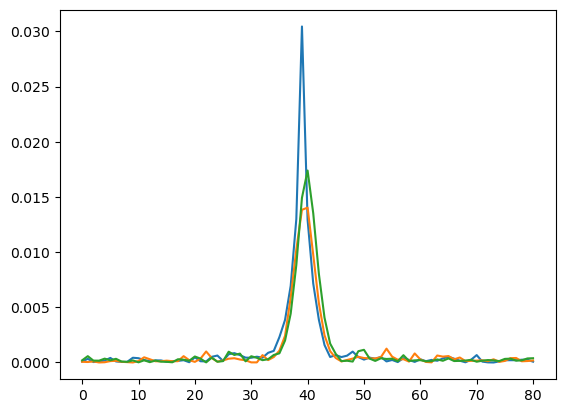

In [82]:
plt.plot(phase_corrs[1000,2,40])
plt.plot(phase_corrs[1100,2,40])
plt.plot(phase_corrs[1400,2,40])

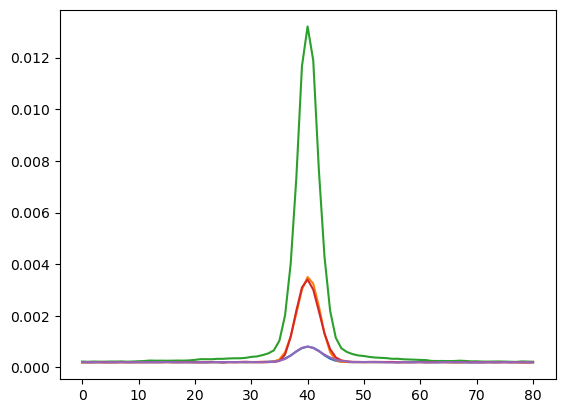

In [78]:
plt.plot(mean_phase_corrs[0,40])
plt.plot(mean_phase_corrs[1,40])
plt.plot(mean_phase_corrs[2,40])
plt.plot(mean_phase_corrs[3,40])
plt.plot(mean_phase_corrs[4,40])

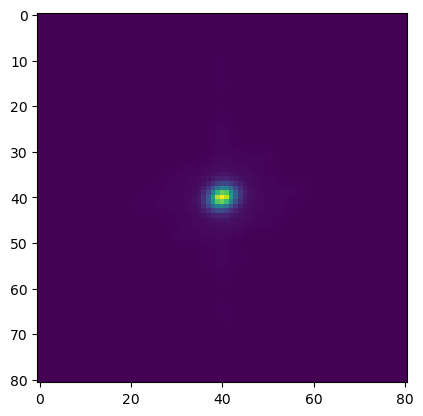

In [72]:
plt.imshow(mean_phase_corrs[2])

In [68]:
phase_corrs.shape

(2000, 5, 81, 81)

In [54]:
os.listdir(job.dirs['registered_fused_data'])

['fused_reg_data0005.npy',
 'reg_metrics_0004.npy',
 'offsets0016.npy',
 'fused_reg_data0002.npy',
 'reg_metrics_0012.npy',
 'fused_reg_data0010.npy',
 'fused_reg_data0009.npy',
 'reg_metrics_0005.npy',
 'mean_img_0004.npy',
 'mean_img_0007.npy',
 'fused_reg_data0006.npy',
 'reg_metrics_0006.npy',
 'mean_img_0009.npy',
 'mean_img_0010.npy',
 'fused_reg_data0011.npy',
 'params.npy',
 'reg_metrics_0009.npy',
 'offsets0004.npy',
 'reg_metrics_0011.npy',
 'mean_img_0003.npy',
 'fused_reg_data0013.npy',
 'offsets0010.npy',
 'reg_metrics_0015.npy',
 'fused_reg_data0001.npy',
 'reg_metrics_0001.npy',
 'mean_img_0015.npy',
 'fused_reg_data0007.npy',
 'fused_reg_data0016.npy',
 'fused_reg_data0004.npy',
 'reg_metrics_0019.npy',
 'reg_metrics_0010.npy',
 'mean_img_0006.npy',
 'mean_img_0013.npy',
 'reg_metrics_0000.npy',
 'offsets0018.npy',
 'offsets0000.npy',
 'reg_metrics_0007.npy',
 'offsets0003.npy',
 'mean_img_0011.npy',
 'fused_reg_data0018.npy',
 'fused_reg_data0000.npy',
 'mean_img_0014.

In [28]:
job.params['fs']

4.116358658453114

In [29]:
reg.keys()

dict_keys(['phase_corr_shifted', 'int_shift', 'pc_peak_loc', 'sub_pixel_shifts', 'metrics'])

In [38]:
# spshift = n.concatenate(reg['sub_pixel_shifts'],axis=0)
# intshift = n.concatenate(reg['int_shift'],axis=0)

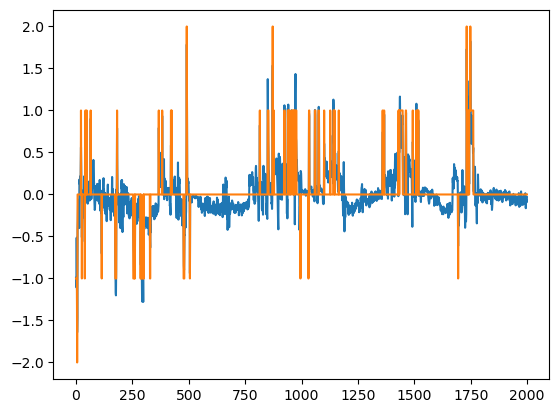

In [39]:
plt.plot(spshift[:,1])
plt.plot(intshift[:,1])

In [40]:
%%time
job.params['voxel_size_um'] = (20, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 200

job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 1.0 # original run with 0.1
corr_map = job.calculate_corr_map()

   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/corrmap with tag corrmap
      Updating self.dirs tag corrmap
   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/mov_sub with tag mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/corrmap
   Updated main params file
   Computing correlation map of movie with 2000 frames, volume shape: 7, 914, 699
      Running batch 1 of 10
         Timer prep completed in 2.611 sec
         Timer batch_setup completed in 0.939 sec
         Timer batch_edgecrop completed in 0.052 sec
         Timer accum_meanmeax completed in 0.697 sec
         Timer batch_rolling_mean_filt completed in 0.672 sec
         Timer batch_accum_sdmov completed in 36.432 sec
         Timer batch_norm_sdmov completed in 0.333 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 2.785 sec
         Subtracting neuropil and applying cell filters
     

In [41]:
corr_map = job.load_corr_map_results()['vmap']

In [42]:
from suite3d import extension as ext

In [43]:
corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

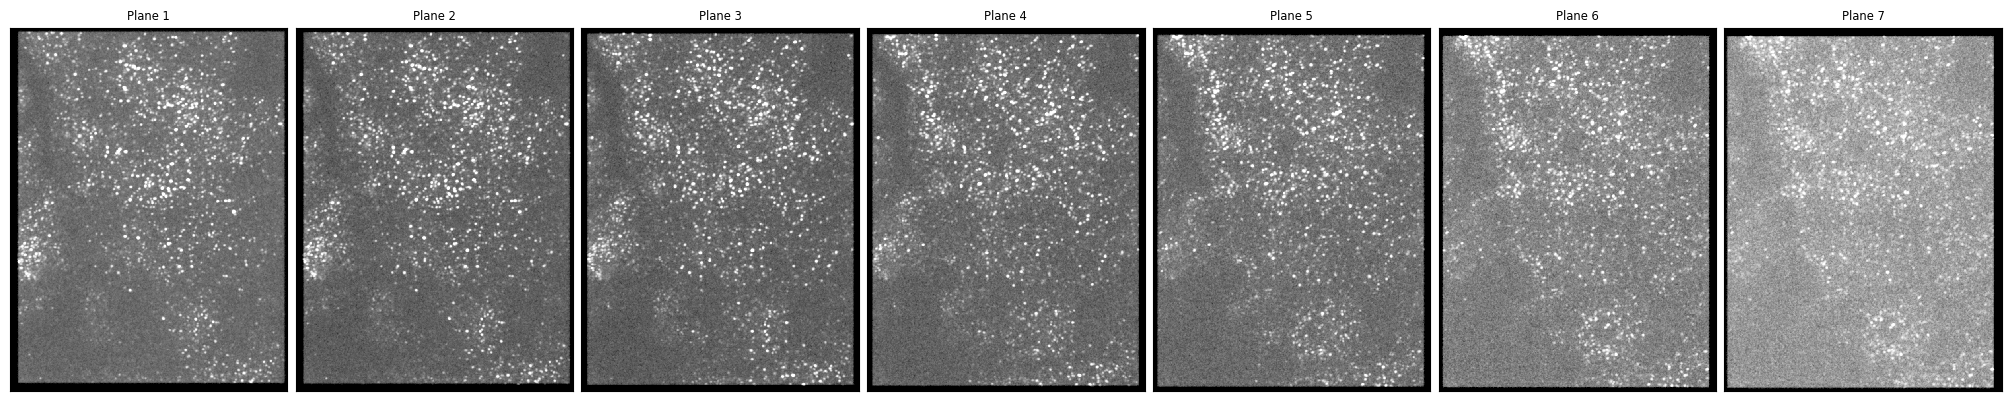

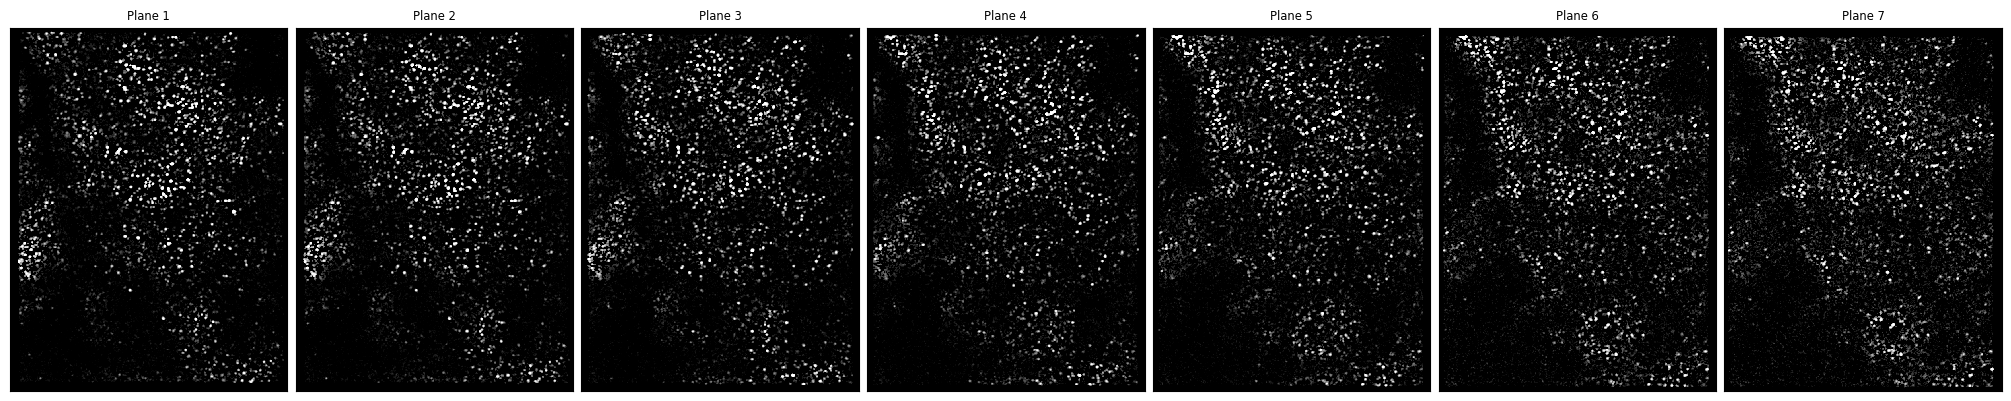

In [44]:
tfu.show_tif_all_planes(corr_map, ncols=7, figsize=(20,5))
tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5))

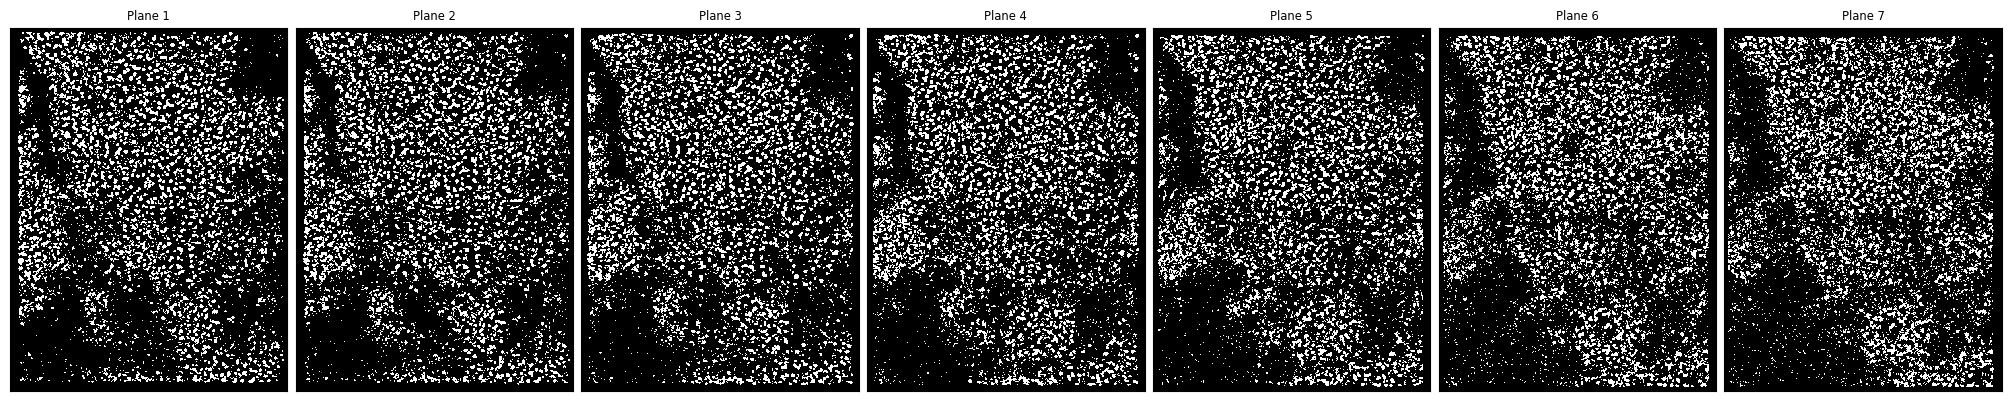

In [47]:

tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5), vminmax=(0.015,0.0151))

In [49]:
%%time
job.params['peak_thresh'] = 0.015
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.0

job.params['extend_thresh'] = 0.05
job.params['activity_thresh'] = 5.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 64
job.params['patch_size_xy'] = (250, 250)

# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=corr_map_thresh)

   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/segmentation with tag segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/segmentation
   Updated main params file
   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois with tag rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/segmentation and /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 12
   Created dir /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/segmentation/patch-0000 with tag segmentation-patch-0000
         Loading 3.26 GB movie to memory, shape: (2000, 7, 250, 250) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.015 and Th2: 5.000
         Iter 0000: running 64 ROIs in parallel
         Ad

'/mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois'

In [52]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')#, additional_info = job.load_corr_map_results())

IOStream.flush timed out
IOStream.flush timed out


   Updated main params file
   Movie shape: (7, 2000, 914, 699)
11413
   Extracting 11413 valid cells, and saving cell flags to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 4 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois
            Extracting batch 0000 of 0004
            Batch size: 8 GB
            Extracting batch 0001 of 0004
            Batch size: 8 GB
            Extracting batch 0002 of 0004
            Batch size: 8 GB
            Extracting batch 0003 of 0004
            Batch size: 8 GB
   Deconvolving
   Saving to /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois
   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-06_1-2-3-4subset to export results
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/info.npy
      

In [53]:
seg = job.load_segmentation_results()
shape = seg['info']['vmap'].shape
cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], shape, lam_max=0.1, cmap='Set1')
nbui.ImageSliceViewer3D(corr_map_thresh,cmap='Greys',vminmax=(job.params['peak_thresh'],job.params['peak_thresh']*2), overlay=rgb_vol, alpha=0.5)

      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/iscell.npy


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [119]:
reg = job.load_registration_results()

In [120]:
shifts = n.concatenate(reg['int_shift'],axis=0)
sp_shifts = n.concatenate(reg['sub_pixel_shifts'], axis=0)

(0.0, 100.0)

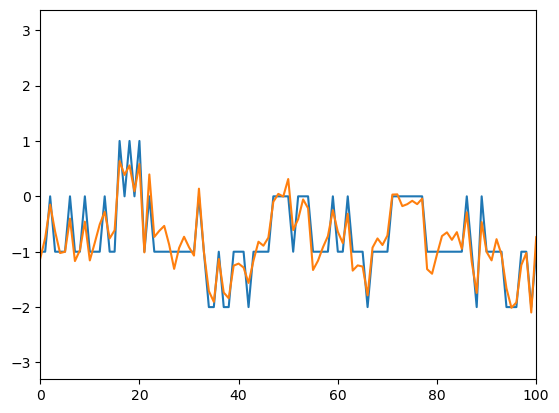

In [121]:
plt.plot(shifts[:,2])
plt.plot(sp_shifts[:,2])
plt.xlim(0,100)

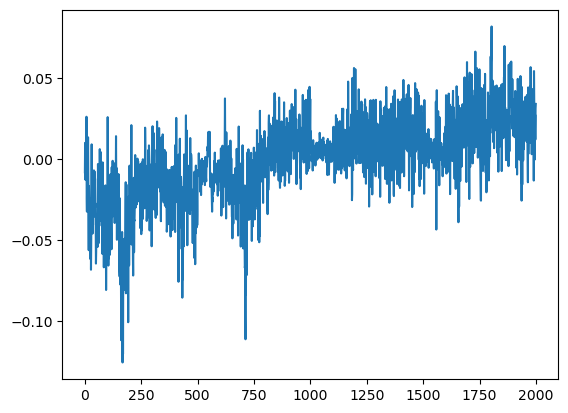

In [122]:
plt.plot(sp_shifts[:,0])